# Proyek Klasifikasi Gambar: Pizza or Not Pizza?
- **Nama:** Naufal Dzakwan Zakianto
- **Email:** naufal.dzakwann28@gmail.com
- **ID Dicoding:** MC012D5Y2416

## Import Semua Packages/Library yang Digunakan

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [2]:
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [3]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

## Data Preparation

Dataset yang digunakan berasal dari kaggle yang bisa di akses melalui: https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza/data

Dataset tersebut berisi sekitar 900 lebih gambar pizza dan 900 lebih gambar hidangan selain pizza. Data merupakan bagian dari himpunan data Food-101.

### Data Loading

In [30]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"naufaldzakwan","key":"8a2220b517066ba766e727d1d73c9202"}'}

In [5]:
import kagglehub
path = kagglehub.dataset_download("carlosrunner/pizza-not-pizza")
print("Path to dataset files:", path)

100%|██████████| 101M/101M [00:00<00:00, 143MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/carlosrunner/pizza-not-pizza/versions/1


### Data Preprocessing

**RESOLUSI GAMBAR PADA DATASET**

In [6]:
import os
from PIL import Image

def get_unique_image_sizes(path):
    unique_sizes = set()
    for root, _, files in os.walk(path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    with Image.open(os.path.join(root, file)) as img:
                        width, height = img.size
                        unique_sizes.add((width, height))
                except IOError:
                    print(f"Error membaca gambar: {os.path.join(root, file)}")
    return unique_sizes


dataset_path = path


unique_sizes = get_unique_image_sizes(dataset_path)

print("Resolusi Gambar berbeda:")
for width, height in unique_sizes:
    print(f"width: {width}, height: {height}")

Resolusi Gambar berbeda:
width: 512, height: 342
width: 512, height: 461
width: 341, height: 512
width: 512, height: 287
width: 512, height: 406
width: 508, height: 512
width: 512, height: 308
width: 512, height: 366
width: 512, height: 372
width: 288, height: 512
width: 343, height: 512
width: 512, height: 439
width: 512, height: 445
width: 512, height: 384
width: 442, height: 512
width: 512, height: 509
width: 512, height: 329
width: 510, height: 512
width: 424, height: 512
width: 512, height: 512
width: 382, height: 512
width: 512, height: 332
width: 512, height: 506
width: 512, height: 335
width: 512, height: 341
width: 512, height: 396
width: 512, height: 451
width: 512, height: 338
width: 512, height: 344
width: 512, height: 289
width: 512, height: 469
width: 512, height: 307
width: 307, height: 512
width: 512, height: 432
width: 384, height: 512
width: 329, height: 512
width: 287, height: 512
width: 507, height: 512
width: 342, height: 512
width: 512, height: 441
width: 512, hei

INSIGHT:

Gambar-gambar pada sumber dataset asli memiliki resolusi yang tidak seragam, sehingga perlu diseragamkan nantinya.

**KONDISI GAMBAR TIAP KELASNYA**

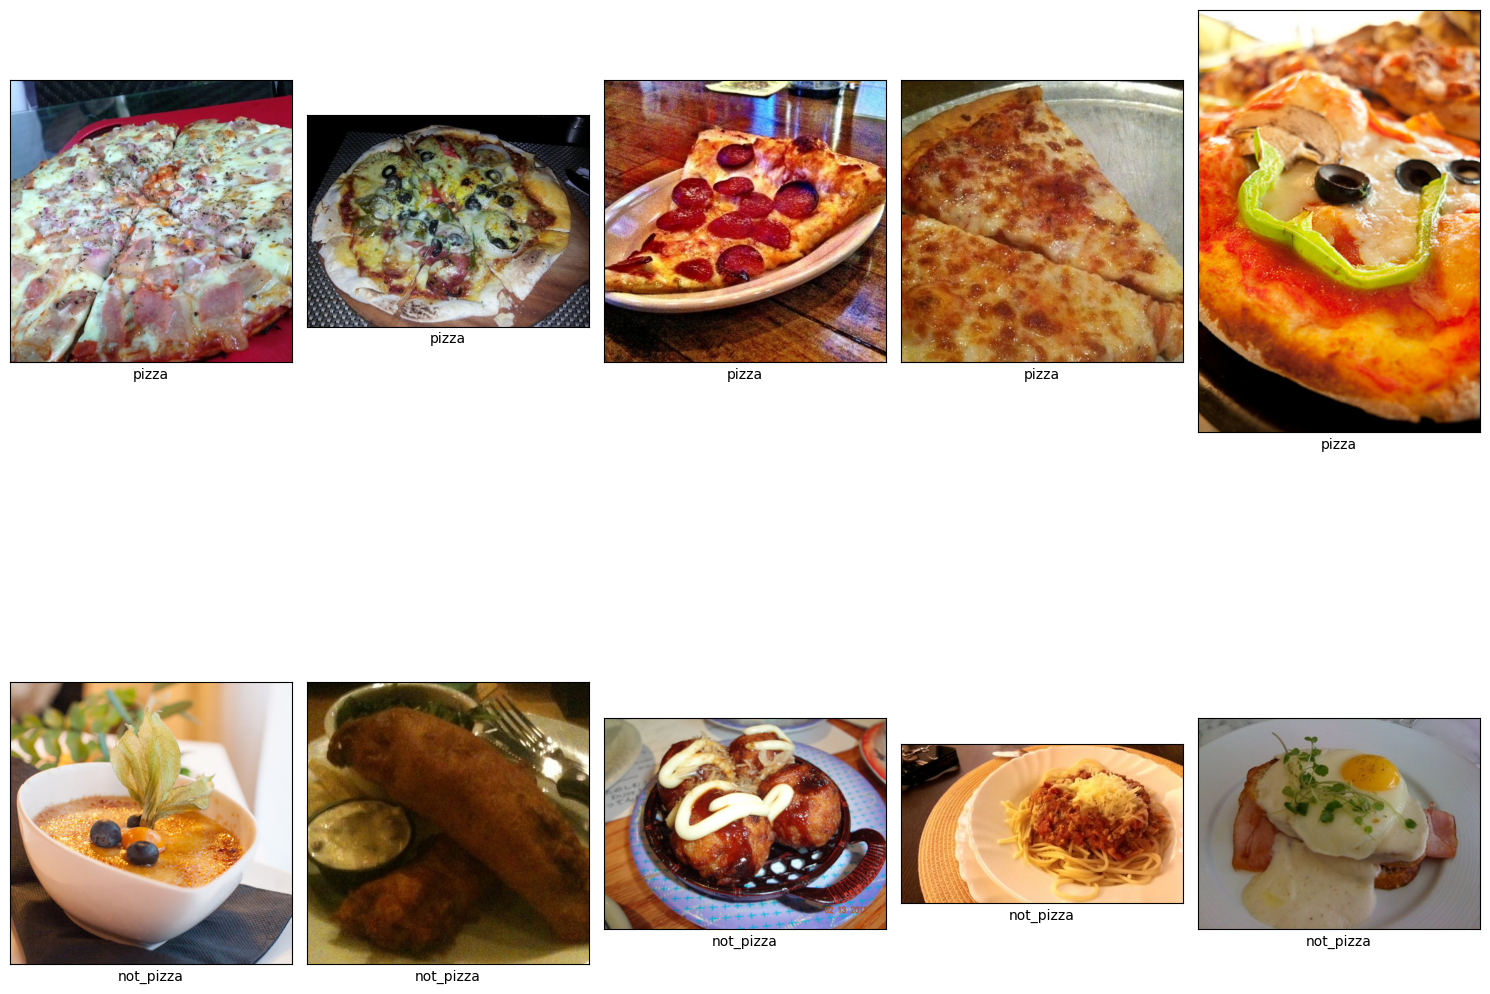

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np


image = {}

path = path
path_sub = os.path.join(path, "pizza_not_pizza")


for i in os.listdir(path_sub):
    if os.path.isdir(os.path.join(path_sub, i)):
        image[i] = [f for f in os.listdir(os.path.join(path_sub, i)) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

fig, axs = plt.subplots(len(image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(image.keys()):
    if image[class_name]:
        images = np.random.choice(image[class_name], 5, replace=False)

        for j, image_name in enumerate(images):
            img_path = os.path.join(path_sub, class_name, image_name)
            img = Image.open(img_path)
            axs[i, j].imshow(img)
            axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

INSIGHT:

ada beberapa gambar dari kelas non_pizza yang memiliki toping dan bentuk menyerupai gambar pada kelas pizza, sehingga akan memberikan tantangan tersendiri nantinya pada saat model melakukan klasifikasi.

**DISTRIBUSI GAMBAR TIAP KELASNYA**

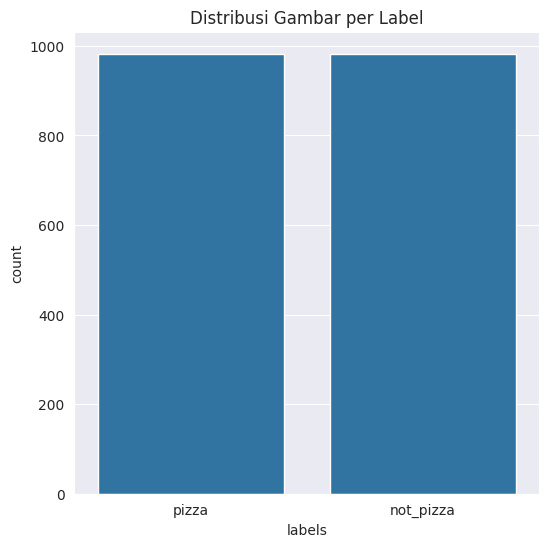

In [8]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

base_path = path

file_name = []
labels = []
full_path = []

for root, dirs, files in os.walk(base_path):
    label = os.path.basename(root)
    if label not in ['pizza', 'not_pizza']:
        continue

    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            file_name.append(file)
            labels.append(label)
            full_path.append(os.path.join(root, file))

distribution_train = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Visualisasi distribusi
plt.figure(figsize=(6,6))
sns.set_style("darkgrid")
sns.countplot(x='labels', data=distribution_train)
plt.title("Distribusi Gambar per Label")
plt.show()


**INSIGHT:**

Distribusi gambar tiap kelasnya seimbang, sehingga ada opsi untuk tidak melakukan undersampling atau oversampling, ataupun penyusaian weight pada masing masing kelas nantinya. Selain itu penggunaan matriks accuracy untuk menilai kinerja model juga cukup adil, sebab dataset masuk kedalam kategori balance (tidak ada kelas yang telalu mendominasi)

**MENGUBAH DATASET KE DATAFRAME AGAR LEBIH MUDAH DI OLAH**

In [9]:
import os
import pandas as pd

mypath = path

file_name = []
labels = []
full_path = []

for root, dirs, files in os.walk(mypath):
    label = os.path.basename(root)
    if label not in ['pizza', 'not_pizza']:
        continue

    for name in files:
        if name.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path.append(os.path.join(root, name))
            labels.append(label)
            file_name.append(name)


df = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})
print(df.groupby('labels').size())


labels
not_pizza    983
pizza        983
dtype: int64


#### Split Dataset

In [10]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=300)

In [11]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [12]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "/kaggle/input/pizza-not-pizza/pizza_not_pizza"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training, validasi dan testing
dataset_path = "Dataset-Final/"


set    labels   
test   not_pizza    149
       pizza        146
train  not_pizza    834
       pizza        837
dtype: int64 


                                                   path     labels    set
1515  /root/.cache/kagglehub/datasets/carlosrunner/p...  not_pizza  train
1285  /root/.cache/kagglehub/datasets/carlosrunner/p...      pizza  train
1278  /root/.cache/kagglehub/datasets/carlosrunner/p...  not_pizza  train
827   /root/.cache/kagglehub/datasets/carlosrunner/p...  not_pizza  train
1840  /root/.cache/kagglehub/datasets/carlosrunner/p...      pizza   test


In [13]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [14]:
# Definisikan direktori training dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"


train_pizza = os.path.join(TRAIN_DIR + '/pizza')
train_not_pizza = os.path.join(TRAIN_DIR + '/not_pizza')

test_pizza = os.path.join(TEST_DIR + '/pizza')
test_not_pizza = os.path.join(TEST_DIR + '/not_pizza')

print("Total number of pizza in training set: ",len(os.listdir(train_pizza)))
print("Total number of not pizza in training set: ",len(os.listdir(train_not_pizza)))
print("Total number of pizza in test set: ",len(os.listdir(test_pizza)))
print("Total number of not pizza in test set: ",len(os.listdir(test_not_pizza)))

Total number of pizza in training set:  837
Total number of not pizza in training set:  834
Total number of pizza in test set:  146
Total number of not pizza in test set:  149


**Image Data Generator**


In [58]:
datagen = ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255,
    validation_split=0.15
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode='binary',
    shuffle=True,
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode='binary',
    shuffle=False,
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=1,
    color_mode="rgb",
    class_mode='binary',
    shuffle=False
)

Found 1421 images belonging to 2 classes.
Found 250 images belonging to 2 classes.
Found 295 images belonging to 2 classes.


**INSIGHT:**

Sampai di tahap ini dataset sudah terbagi menjadi tiga bagian yaitu training 70%, validasi 15%, dan testing 15%

## Modelling

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import MobileNetV2


model_1 = Sequential()


base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False
model_1.add(base_model)


model_1.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_1.add(MaxPooling2D((2, 2)))

model_1.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_1.add(MaxPooling2D((2, 2)))

model_1.add(GlobalAveragePooling2D())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,085,825 (11.77 MB)

 Trainable params: 827,841 (3.16 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]


history_1 = model_1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=callbacks,
    verbose = 1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.6281 - loss: 0.6794
Epoch 1: val_accuracy improved from -inf to 0.89600, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 776ms/step - accuracy: 0.6308 - loss: 0.6755 - val_accuracy: 0.8960 - val_loss: 0.2484
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9107 - loss: 0.2312
Epoch 2: val_accuracy improved from 0.89600 to 0.92000, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 495ms/step - accuracy: 0.9107 - loss: 0.2314 - val_accuracy: 0.9200 - val_loss: 0.2158
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9327 - loss: 0.1862
Epoch 3: val_accuracy did not improve from 0.92000
45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 460ms/step - accuracy: 0.9325 - loss: 0.1865 - val_accuracy: 0.9080 - val_loss: 0.2031
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9345 - loss: 0.1852
Epoch 4: val_accuracy did not improve from 0.92000
45/45 ━━━━━━━━━━━━━━━━━━━

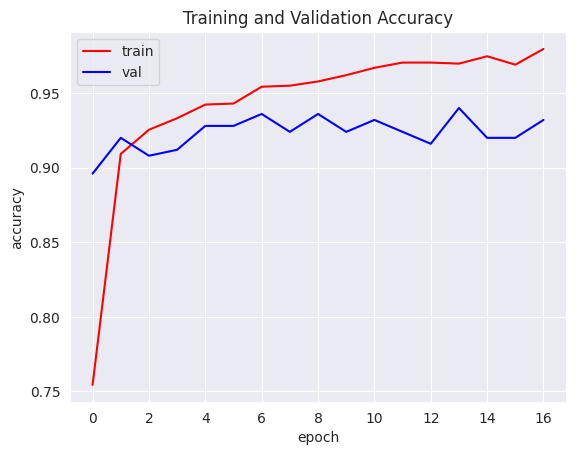

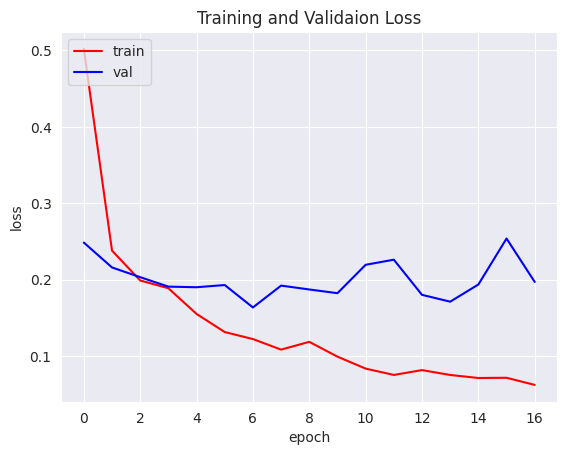

In [18]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

**INSIGHT:**

Model sudah memiliki performa yang cukup baik, tidak overfit ataupun underfit. Hal ini bisa dilihat dari performa akurasi dan loss yang tidak berbeda jauh antara training dan validasi. Selain itu jika dilihat pada epoch terbaik yakni "7", model memiliki **accuracy training sebesar 95.77%** dan loss: 0.1136 serta **accuracy validasi sebesar 93.60%** dan loss: 0.1634.

## Evaluasi dan Visualisasi

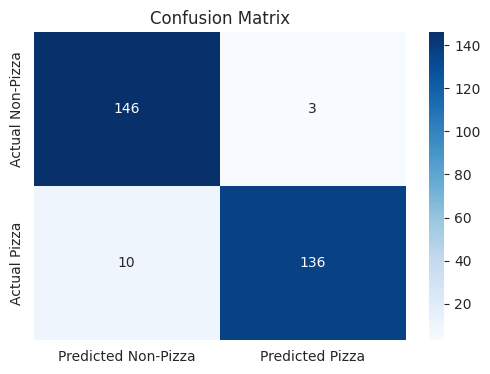


Classification Report:
              precision    recall  f1-score   support

   Non-Pizza     0.9359    0.9799    0.9574       149
       Pizza     0.9784    0.9315    0.9544       146

    accuracy                         0.9559       295
   macro avg     0.9572    0.9557    0.9559       295
weighted avg     0.9569    0.9559    0.9559       295



In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Reset generator agar evaluasi dimulai dari awal
test_generator.reset()

# Prediksi
preds_1 = model_1.predict(test_generator, verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

# Confusion Matrix
cm = pd.DataFrame(
    data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),
    index=["Actual Non-Pizza", "Actual Pizza"],
    columns=["Predicted Non-Pizza", "Predicted Pizza"]
)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(
    y_true=test_generator.classes,
    y_pred=preds_1,
    target_names=['Non-Pizza', 'Pizza'],
    digits=4
))


INSIGHT:

Dari classification report di atas, dapat dilihat bahwa model memiliki **akurasi sebesar 95.59%**, yang berarti sebagian besar dari prediksinya benar. Selain itu, untuk kelas "Pizza", precisionnya adalah 97.84%, yang berarti dari semua kasus yang diprediksi sebagai "Pizza", 97.84% di antaranya benar-benar "Normal". Untuk kelas "Non Pizza", precisionnya adalah 93.59%, yang berarti dari semua kasus yang diprediksi sebagai "Non Pizza", 93.59% di antaranya benar-benar "Non Pizza". Fakta ini menunjukkan bahwa model cenderung memberikan sedikit false positive. Adapun untuk recall, kelas "Pizza", recall-nya adalah 93.15%. Ini berarti dari semua kasus "Pizza" yang sebenarnya, model berhasil mengidentifikasi 93.15% di antaranya. Untuk kelas "Non Pizza", recall-nya adalah 97.99%. Ini berarti dari semua kasus "Non Pizza" yang sebenarnya, model berhasil mengidentifikasi  97.99% di antaranya. Hal ini menunjukkan bahwa model cenderung memberikan sedikit false negative. F1-score adalah rata-rata harmonik dari precision dan recall yang memberikan gambaran keseluruhan tentang kinerja model. F1-score untuk kelas "Pizza" adalah 95.44%, sementara untuk kelas "Non Pizza" adalah 95.74%.

Kesimpulannya,  hasil evaluasi menunjukkan bahwa model memiliki kinerja yang baik dalam membedakan antara gambar pizza dengan non pizza.

## Konversi Model

**MELAKUKAN KONVERSI MODEL KE FORMAT TFjs**

In [23]:
!pip install tensorflowjs

In [32]:
import tensorflowjs as tfjs
from tensorflow import keras
model_1.save('best_model.keras')
tfjs.converters.save_keras_model(model_1, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


**MELAKUKAN KONVERSI MODEL KE FORMAT TFlite**

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp9w6wl7ur'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132507468070160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507464092368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507464092752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507468069584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507468070736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507468069392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507464091984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507464091216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507464093136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507464092944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1325074640

**MELAKUKAN KONVERSI MODEL KE FORMAT SAVED_MODEL**

In [20]:
model_1.export("saved_model/saved_model")

Saved artifact at 'saved_model/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132507468070160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507464092368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507464092752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507468069584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507468070736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507468069392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507464091984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507464091216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507464093136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132507464092944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132

## Inference (Optional)

In [34]:
model = tf.keras.models.load_model('best_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [57]:
from tensorflow.keras.utils import load_img, img_to_array

def predict_image(img_path, model, target_size=(224, 224), threshold=0.5):
    img = load_img(img_path, target_size=target_size)

    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    label = 'pizza' if prediction > threshold else 'non_pizza'

    print(f"Confidence: {prediction:.4f}")
    print(f"Prediction: {label}")
    return label

INFERENSI UNTUK GAMBAR KELAS PIZZA

In [55]:
predict_image(path+'/pizza_not_pizza/pizza/1001116.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Confidence: 0.9998
Prediction: pizza


'pizza'

INFERENSI UNTUK GAMBAR KELAS NON PIZZA

In [56]:
predict_image(path+'/pizza_not_pizza/not_pizza/1005746.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Confidence: 0.1361
Prediction: non_pizza


'non_pizza'

**INSIGHT:**

Model berhasil melakukan klasifikasi pada gambar dengan kelas pizza maupun non pizza dengan benar dan tepat.